In [1]:
import numpy as np #importing packages
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from dataset_tools import MNIST
from plotting import loss_plots, plot_random_images, plot_image_comparison
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
# notice that we dont flatten the images now

data_train = MNIST(train=True, transform=ToTensor())
data_test = MNIST(train=False, transform=ToTensor())

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=False, pin_memory=cuda)


In [3]:
# test to see if the shape is correct

x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


# VAE

In [4]:

# input img -> hidden -> mu, logvar -> reparameterization trick (sample point from distribution made from mu, logvar) -> decoder -> output img
from models import VAE_MNIST_CNN
from loss_functions import loss_function


model = VAE_MNIST_CNN(input_dim=(28,28), hidden_dim=256, latent_dim=2)
print(model)
if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


VAE_MNIST_CNN(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=256, bias=True)
    (8): ReLU()
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (sigma): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=6272, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1

In [5]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat, mu, sigma = output
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 1, 28, 28])
x_hat.shape: torch.Size([64, 1, 28, 28])


## Training

In [6]:
num_epochs = 5

train_loss = []
train_mse_loss = []
train_kld_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        x_hat, mu, sigma = model(x)
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")




Epoch 1/5, loss: 2924.169074019898, mse: 2731.454581124442, kld: 192.71449537139966
Epoch 2/5, loss: 2527.5743634644855, mse: 2249.3683879014525, kld: 278.20597431044587
Epoch 3/5, loss: 2449.7968466297143, mse: 2153.5573285393625, kld: 296.23952248254056
Epoch 4/5, loss: 2401.580508624567, mse: 2094.1441604842003, kld: 307.4363476360785
Epoch 5/5, loss: 2362.5360212834403, mse: 2045.158188354232, kld: 317.37783133500676


## Plots

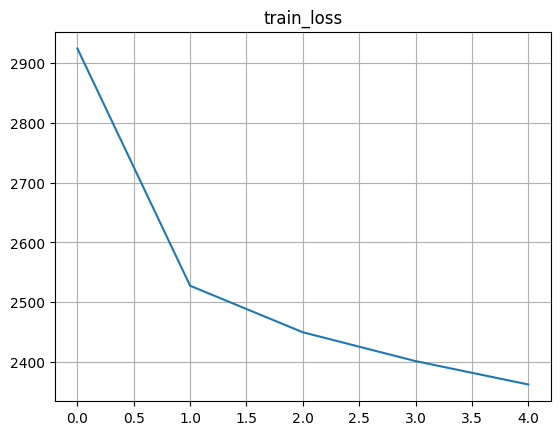

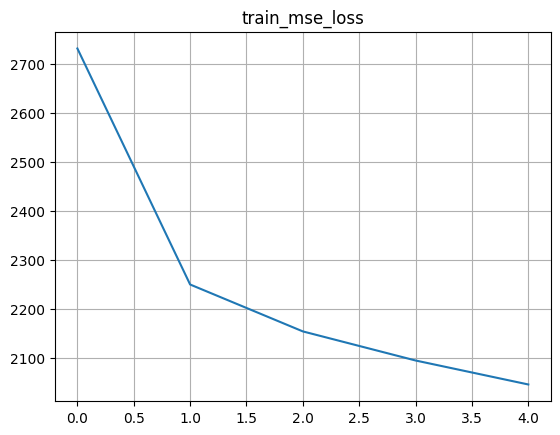

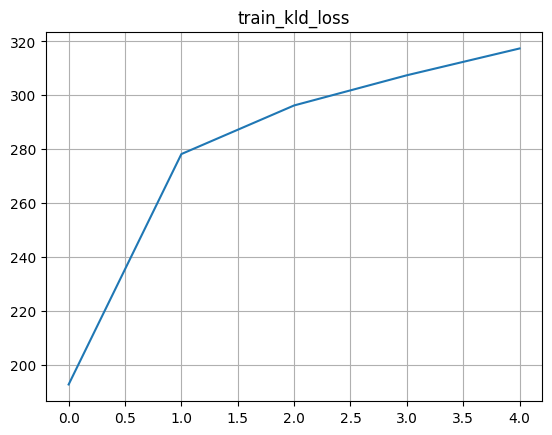

In [7]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss


loss_plots(loss_data, invidual_plots=True)

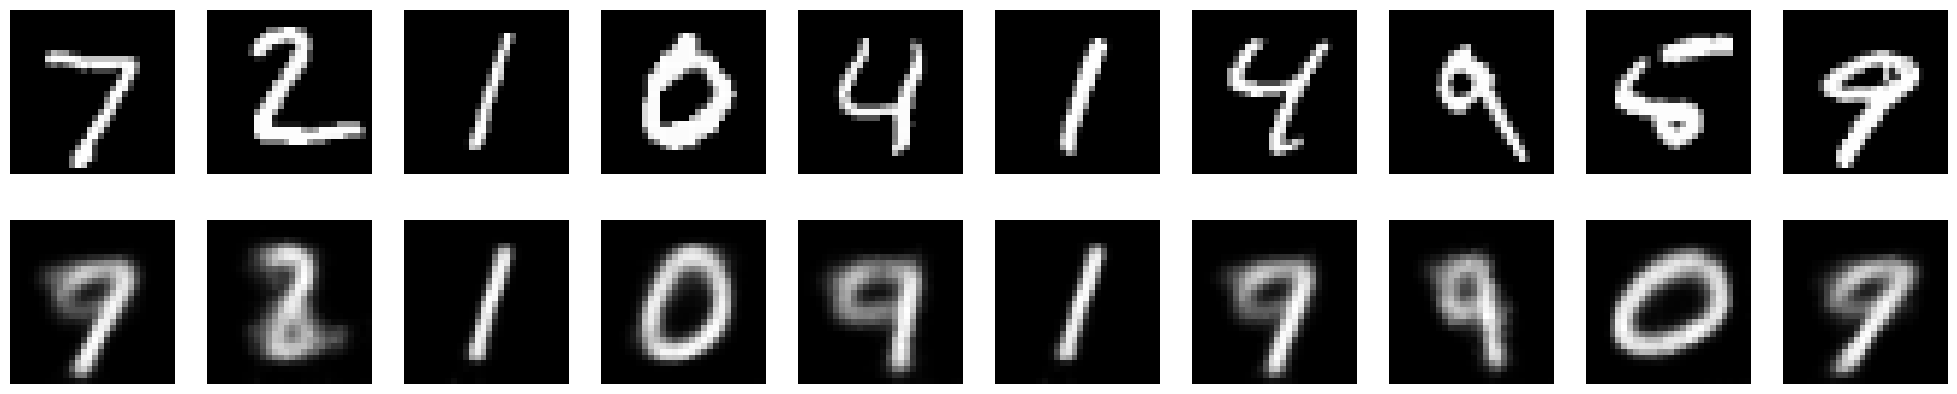

In [8]:
# test the model
plot_image_comparison(model, test_loader, cuda)